<div class="alert alert-block alert-danger">
<h1>Bank Customer Churn</h1>
</div>

- Goal is to predict which customers are likely to leave the bank using customer data.

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Functions to be used](#1.0)<br>
    <ul>
        <li>Pandas</li>
        <li>Visualizations</li>
        <li>Confusion matrix and metrics</li>
        <li>Encoding</li>
        <li>KBinsDiscretizer</li>
        <li>Standardization</li>
    </ul>
[Importing Libraries](#2.0)<br>
[Load The Data](#3.0)<br>
[Exploratory Data Analysis (EDA)](#4.0)<br>
    <ul>
        <li>[Analyze each feature](#4.1)</li>
    </ul>
[Machine Learning Algorithms and Results](#5.0)<br>
    <ul>
        <li>[Feature engineering](#5.1)</li>
        <li>[Correlation of the features](#5.2)</li>
        <li>[Split Dataframe](#5.3)</li>
        <li>[Overcoming Class Imbalance using SMOTE](#5.4)</li>
        <li>[Building ML models](#5.5)</li>
            <ul>
                <li>Logistic Regression</li>
                <li>Random Forest</li>
                <li>Naive Bayes</li>
                <li>Support Vector</li>
                <li>k-Nearest Neighbours</li>
                <li>Stochastic Gradient Descent</li>
                <li>Gradient-Boosted Tree</li>
                <li>XGBClassifier</li>
            </ul>
        <li>[Model selection - final](#5.6)</li>
        <li>[Evaluation of the selected model](#5.7)</li>
            <ul>
                <li>ROC/AUC</li>
                <li>TPR/TNR - Threshold</li>
                <li>Precision(PPV)/NPV - Recall</li>
                <li>Accuracy - Threshold</li>
            </ul>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Functions to be used</h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pandas
    </h4>
</div>

In [1]:
def count_null_columns(df):
    df_null = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_null = df_null[df_null["count"] != 0]
    if len(df_null.index) > 0:
        return df_null[df_null['count']>0]
    else:
        print("There are no null values in the dataframe.")

In [2]:
def percentCol(df, col):
    df1 = df.groupby(col)[col].count().rename("count").reset_index().sort_values("count", ascending=False)
    df1["percentage (%)"] = 100*df1["count"] / df1["count"].sum()
    df1 = df1.round({"percentage (%)": 1})
#     df1 = df1.fillna('nan')
    df1.set_index(df1.columns[0], inplace=True)
    if len(df1) > 10:
        df1 = df1[:8]
        print("The first 8 items have been plotted.")
    return df1

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

def evaluate_model(model, X_train, y_train, X_test, y_test, params):
    cv = GridSearchCV(estimator=model, cv=10, scoring='accuracy', param_grid=params, 
                       n_jobs=-1).fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    y_pred_proba = cv.predict_proba(X_test)
#     print(y_pred)
#     print(cv_pred)
    
    model_cm = confusion_matrix(y_test, y_pred)
    model_cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    model_cm_metrics = confusion_matrix_func(model_cm, model_cm_norm)
    
    return model_cm_metrics, y_pred_proba

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [4]:
# plot a stacked bar chart to show how a feature is categorized using the another feature
def stacked_bar_chart(df_target, target_col, col, figsize=(8,5)):
    
    df = df_target.groupby([target_col])[col].value_counts(dropna=False).to_frame()\
        .rename(columns={col: 'count'}).reset_index()\
        .pivot(index=target_col, columns=col, values='count').fillna(0)
    
    df["sum_each"] = df[0] + df[1]
    df.sort_values("sum_each", ascending=False, inplace=True)
    df.drop("sum_each", axis=1, inplace=True)

    if len(df) > 10:
        df = df.iloc[:8, :]
        print("The first 8 items have been plotted.")
    
    print(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35
    
    colors = []
    for column in df.columns:
        if str(column) == '0':
            colors.append('royalblue')
        elif str(column) == '1':
            colors.append('mediumvioletred')
    
    x = [str(i) for i in df.index]
    y = 0
    for i, col_group in enumerate(df.columns):
        try:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors[i], label=df.columns[i], 
                   zorder=3)
        except:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors(i), label=df.columns[i], 
                   zorder=3)
        y += df[col_group].values
    
    ax.set_xticklabels(x, rotation = 45)
    
    ax.set_xlabel(df.index.name)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(axis='y', zorder=0, lw=0.2)
        
    plt.show()

In [5]:
def autopct(pct_max, pct, allvals):
    if pct<pct_max:
        return ""
    else:
        absolute = int(round(pct/100.*sum(allvals), 0))
        return "{p:.1f}% \n({val})".format(p=pct, val=absolute)

def pie_chart(df, explode=None, title=None, pct_max=5, legend_pos=(0.8, 0, 0.4, 1), 
              p_theta_max=15, p_theta_min=2):
#     df = df.toPandas().set_index(df.columns[0])
#     df.index.name = None
    items = df.index
    values = df.iloc[:, 0]
    percent = df.iloc[:, 1]
    
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    #################################################################
    textprops = dict(horizontalalignment="center", verticalalignment="center", rotation=0, 
                     rotation_mode="anchor", size=12, weight= "bold", color="white")
    wedgeprops=dict(edgecolor="black", linewidth=1)
    labels = [f"{i} ({j} - {k:1.1f}%)" for i,j,k in zip(items, values, percent)]
    #################################################################
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: autopct(pct_max, pct, values), 
                                      textprops=textprops, radius=1, startangle=0, counterclock=True, 
                                      pctdistance = 0.6, wedgeprops=wedgeprops, explode=explode)
    #################################################################
    #---------------------------------------------------------------#
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center", ha="center")

    values_2 = [f"{i:1.1f}% ({j})" for i,j in zip(percent, values)]

    for i, p in enumerate(wedges):
        if (p.theta2 - p.theta1 < p_theta_max) & (p.theta2 - p.theta1 > p_theta_min):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.annotate(values_2[i], xy=(x, y), xytext=(1.6*np.sign(x), 1.5*y),
                        horizontalalignment=horizontalalignment, **kw)
    #---------------------------------------------------------------#
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size=16, weight="bold")

    plt.legend(labels=labels, fontsize=12, bbox_to_anchor=legend_pos)
        
    plt.show()

In [6]:
from scipy import stats

def histogram(df, target_col, figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

#     age_vals = [i[0] for i in df.select(target_col).na.drop().collect()]
    age_vals = [i for i in df[target_col].dropna()]
    
    sigma = df[target_col].dropna().std() # standard deviation of distribution
    mean = df[target_col].dropna().mean() # mean of distribution
    median = np.median(age_vals)
    mode = stats.mode(age_vals)[0][0]   

    x = mean + sigma * np.random.randn(1000)

    # fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    n, bins, patches = ax.hist(age_vals, 20, density=True, color='lightgreen', 
                                           stacked=True, alpha=0.75)

    # add mean, median and mode lines
    ax.axvline(mean, 0, 1, color='red', label='mean: {:.2f}'.format(mean))
    ax.axvline(median, 0, 1, color='blue', label='median: {:.2f}'.format(median))
    ax.axvline(mode, 0, 1, color='green', label='mode: {:.2f}'.format(mode))

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--', color ='black')

    ax.grid(True)
    ax.set_ylabel('Probability')
    ax.set_title(f'{target_col} (sigma={round(sigma, 2)})')
    ax.legend()
    fig.tight_layout()
    fig.show()

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" style="height:250px">

median (Q2/50th Percentile): the middle value of the dataset<br>
first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.<br>
third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.<br>
interquartile range (IQR): 25th to the 75th percentile.<br>
whiskers (shown in blue)<br>
outliers (shown as green circles)<br>
“maximum”: Q3 + 1.5*IQR<br>
“minimum”: Q1 -1.5*IQR<br>

In [7]:
# plot a boxplot to show how the values in the dataset are spread out
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)

    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()

In [8]:
def balanceOrInbalance(df_label):
    col = df_Exited.index.name
    uniqs = [str(i) for i in df_label.index]
    vals = [i for i in df_label["count"].values]
    
    fig, ax = plt.subplots(figsize = (12, 2))
    # Horizontal bar chart
    ax.barh(uniqs, vals, align='center', color=['red', 'green'])
    ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
    ax.text(vals[1]-vals[1]*0.2, 1, vals[1], ha='center', va='center', color='w', size=20)
    ax.set_ylabel(col)
    ax.set_title('Balance situation in the dependent feature')

    plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [9]:
import math

def TP_FP_TN_FN_func(cm, dataframe):
    
    TN, FP, FN, TP = cm.ravel()

    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    

    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 
                    'Precision', 'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    df_cm_metrics = pd.DataFrame([[TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR]], 
                                 columns=metrics_cols, index=[""])
    
    return df_cm_metrics

def confusion_matrix_func(cm, cm_norm, threshold=0.5):
    cm = cm.astype(int)

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    im_norm = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Reds', aspect='auto')
    
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    axes[1].set_xticks(np.arange(len(cm_norm.tolist())))
    axes[1].set_yticks(np.arange(len(cm_norm.tolist())))

    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
            
    for i in range(len(cm_norm.tolist())):
        for j in range(len(cm_norm.tolist())):
            text = axes[1].text(j, i, f"{round(cm_norm.tolist()[i][j]*100, 1)} %",
                           ha="center", va="center", size=16,
                           color="white" if cm_norm[i, j] > 0.5 else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Predicted value', size=16)
    axes[0].set_ylabel('Actual value', size=16)
    axes[0].set_title("Confusion matrix", fontsize=16, color="blue")

    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Predicted value', size=16)
    axes[1].set_ylabel('Actual value', size=16)
    axes[1].set_title("Normalized confusion matrix", fontsize=16, color="blue")
    
    fig.tight_layout()
    fig.show()
    
#     get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Test')
    
    return df_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Encoding
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [10]:
# One Hot Encoding: Encode categorical features as a one-hot numeric array.
# find the unique values per feature and transform the data to a binary one-hot encoding
from sklearn.preprocessing import OneHotEncoder

def ohe_to_df(df_encoded, ohe_col_name, df_org, ohe_col):
    df_enc = pd.DataFrame(data=df_encoded, columns=ohe_col_name)
    
    # Some rows can be deleted since they are outliers.
    # Therefore, the index numbers are replaced with the existing dataframe
    df_enc.set_index(df_org.index, inplace=True)
    
    # drop the feature to be encoded from the main dataframe and 
    # concatenate the main dataframe with the encoded one
    df_org_dropped = df_org.drop(ohe_col, axis=1)
    df_finished = pd.concat([df_org_dropped, df_enc], axis=1)
    df_finished[ohe_col_name] = df_finished[ohe_col_name].astype(int)
    
    return df_finished
    
# One Hot Encoding the columns.
def one_hot_encoding(train=None, test=None, ohe_col=None):
    train_for_ohe = train[[ohe_col]]
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Fit OneHotEncoder to X, then transform X
    ohe.fit(train_for_ohe)
    train_encoded = ohe.transform(train_for_ohe)

    # create feature names for the created binary columns using the feature name to be encoded and uniques
    ohe_col_name = ohe.get_feature_names([ohe_col]).tolist()
    
    df_train_encoded = ohe_to_df(train_encoded, ohe_col_name, train, ohe_col)
    
    if test:
        test_for_ohe = test[[ohe_col]]
        test_encoded = ohe.transform(test_for_ohe)
        df_test_encoded = ohe_to_df(test_encoded, ohe_col_name, test, ohe_col)

        return df_train_encoded, df_test_encoded
    return df_train_encoded

In [11]:
# Convert each value in a categorical column to a number from 0 to the number of items-1 by encoding 
def encode_categorical_column(df, col):
    # get unique values
    unique_vals = df[col].value_counts(dropna=True).index.to_list()
    
    if df[col].dtypes == 'object':
        # get a counter in the for loop and replace each unique value with the count to encode 
        for i, j in enumerate(unique_vals):
            df[col].replace(j, i, inplace=True)
    return df

<div class="alert alert-block alert-success">
    <h4>
        KBinsDiscretizer
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html?highlight=kbinsdiscretizer#sklearn.preprocessing.KBinsDiscretizer

In [12]:
from sklearn.preprocessing import KBinsDiscretizer

def k_bins_discretizer(df, col_kbd, n_bins, strategy):
    kbd = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = strategy)
    df[col_kbd] = kbd.fit_transform(df[col_kbd].values.reshape(-1,1)).astype('int64')

    return df

<div class="alert alert-block alert-success">
    <h4>
        Standardization (StandardScaler)
    </h4>
</div>

In [13]:
from sklearn.preprocessing import StandardScaler

def standardisation(train=None, test=None, col=None):
    train_for_scaler = train[[col]]
    
    scaler = StandardScaler()
    scaler.fit(train_for_scaler)
    
    # Discretize the data
    train_scaled = scaler.transform(train_for_scaler)
    train[col] = train_scaled
    
    if test:
        test_for_scaler = test[[col]]
        test_scaled = scaler.transform(test_for_scaler)
        test[col] = test_scaled
        return train, test
    return train

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Import Libraries</h2>
</div>

In [14]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
# # natural images of 10 different classes with 50000 training and 10000 test grayscale 32x32 pixels RGB images
# from tensorflow.keras import Sequential, Input, Model
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.activations import relu

<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Load Data</h2>
</div>

In [15]:
df = pd.read_csv('../../all_dfs/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<strong>Content</strong><br>
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.<br>
- CustomerId: Unique Ids for bank customer identification
- Surname: Customer's last name
- CreditScore: Credit score of the customer
- Geography: The country from which the customer belongs
- Gender: Male or Female
- Age: Age of the customer
- Tenure: Number of years for which the customer has been with the bank
- Balance: Bank balance of the customer
- NumOfProducts: Number of bank products the customer is utilising
- HasCrCard: Binary Flag for whether the customer holds a credit card with the bank or not
- IsActiveMember: Binary Flag for whether the customer is an active member with the bank or not
- EstimatedSalary: Estimated salary of the customer in Dollars
- Exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

In [16]:
f"Total transactions: {df.shape[0]}"

'Total transactions: 10000'

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Exploratory Data Analysis (EDA)</h2>
</div>

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Check missing values
</div>

In [17]:
count_null_columns(df)

There are no null values in the dataframe.


<div class="alert alert-block alert-success">
    <h4>
        Exited
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Distribution of total transactions
</div>

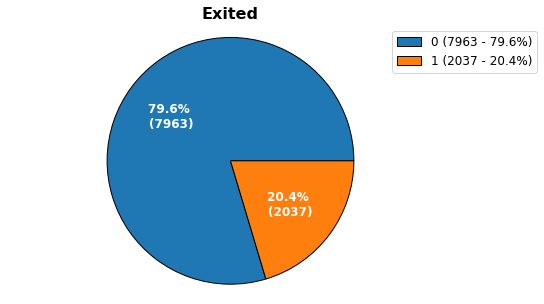

In [18]:
df_Exited = percentCol(df, 'Exited')
pie_chart(df_Exited, title='Exited')

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

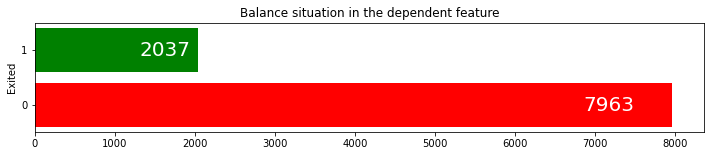

In [19]:
balanceOrInbalance(df_Exited)

- The difference between 0 and 1 values in the dependent feature is not same. So the dataset is in imbalance.

<div class="alert alert-block alert-success">
    <h4>
        Geography
    </h4>
</div>

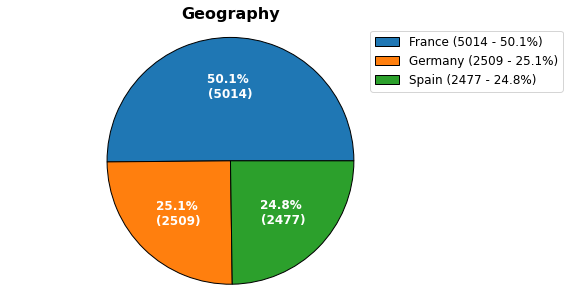

In [20]:
df_Geography = percentCol(df, 'Geography')
pie_chart(df_Geography, title='Geography')

Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413


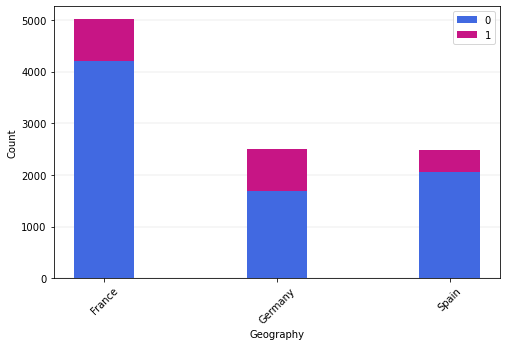

In [21]:
stacked_bar_chart(df, "Geography", "Exited")

In [22]:
# France
print('{:.1%} of France customers closed their accounts.'.format(810/(4204+810)))
print('=====')
# Germany
print('{:.1%} of German customers closed their accounts.'.format(814/(1695+814)))
print('=====')
# Spain
print('{:.1%} of Spain customers closed their accounts.'.format(413/(2064+413)))


16.2% of France customers closed their accounts.
=====
32.4% of German customers closed their accounts.
=====
16.7% of Spain customers closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [23]:
df = one_hot_encoding(train=df, ohe_col='Geography')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        Gender
    </h4>
</div>

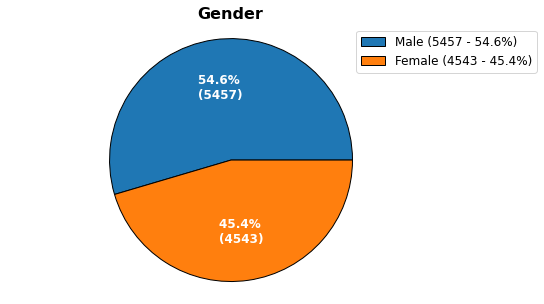

In [24]:
df_Gender = percentCol(df, 'Gender')
pie_chart(df_Gender, title='Gender')

Exited     0     1
Gender            
Male    4559   898
Female  3404  1139


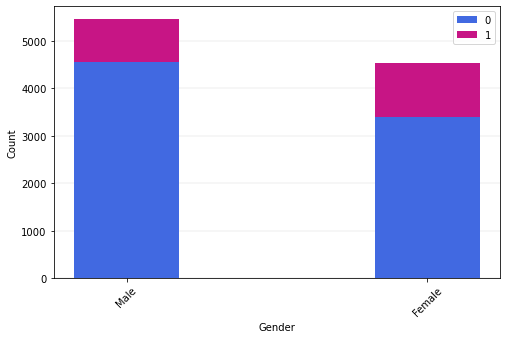

In [25]:
stacked_bar_chart(df, "Gender", "Exited")

In [26]:
print('{:.1%} of Female customers closed their accounts.'.format(1139/(3404+1139)))
print('=====')
print('{:.1%} of Male customers closed their accounts.'.format(898/(4559+898)))

25.1% of Female customers closed their accounts.
=====
16.5% of Male customers closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [27]:
df = one_hot_encoding(train=df, ohe_col='Gender')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


<div class="alert alert-block alert-success">
    <h4>
        NumOfProducts
    </h4>
</div>

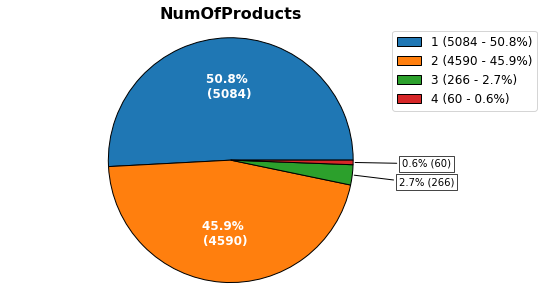

In [28]:
df_NumOfProducts = percentCol(df, 'NumOfProducts')
pie_chart(df_NumOfProducts, title='NumOfProducts')

Exited              0       1
NumOfProducts                
1              3675.0  1409.0
2              4242.0   348.0
3                46.0   220.0
4                 0.0    60.0


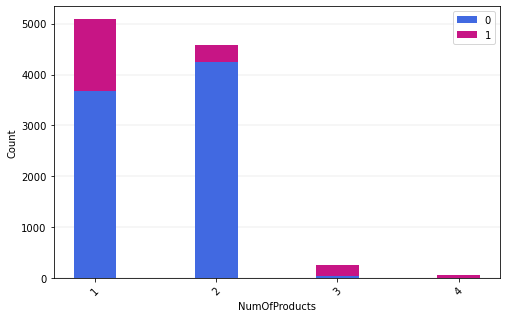

In [29]:
stacked_bar_chart(df, "NumOfProducts", "Exited")

In [30]:
print('{:.1%} of customers use 1 of bank products closed their accounts.'.format(1409/(3675+1409)))
print('=====')
print('{:.1%} of customers use 2 of bank products closed their accounts.'.format(348/(4242+348)))
print('=====')
print('{:.1%} of customers use 3 of bank products closed their accounts.'.format(220/(46+220)))
print('=====')
print('{:.1%} of customers use 4 of bank products closed their accounts.'.format(60/(0+60)))

27.7% of customers use 1 of bank products closed their accounts.
=====
7.6% of customers use 2 of bank products closed their accounts.
=====
82.7% of customers use 3 of bank products closed their accounts.
=====
100.0% of customers use 4 of bank products closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [31]:
df = one_hot_encoding(train=df, ohe_col='NumOfProducts')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,1,15634602,Hargrave,619,42,2,0.00,1,1,101348.88,1,1,0,0,1,0,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,0,1,112542.58,0,0,0,1,1,0,1,0,0,0
2,3,15619304,Onio,502,42,8,159660.80,1,0,113931.57,1,1,0,0,1,0,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,0,0,93826.63,0,1,0,0,1,0,0,1,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0,1,0,0,0


<div class="alert alert-block alert-success">
    <h4>
        HasCrCard
    </h4>
</div>

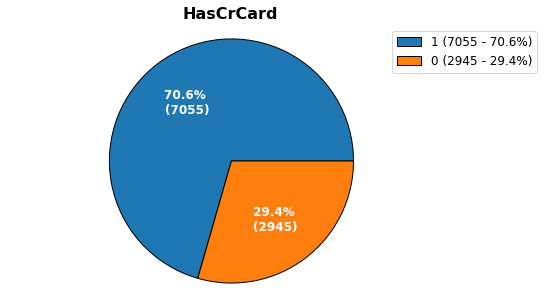

In [32]:
df_HasCrCard = percentCol(df, 'HasCrCard')
pie_chart(df_HasCrCard, title='HasCrCard')

Exited        0     1
HasCrCard            
1          5631  1424
0          2332   613


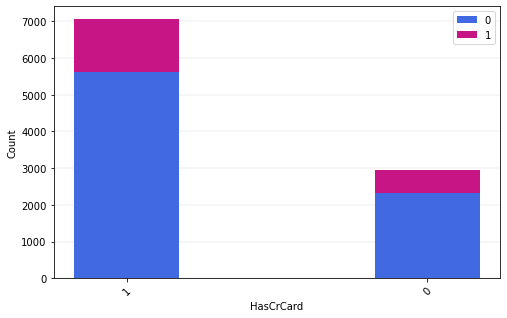

In [33]:
stacked_bar_chart(df, "HasCrCard", "Exited")

In [34]:
print('{:.1%} of customers does not have a credit card closed their accounts.'.format(613/(2332+613)))
print('=====')
print('{:.1%} of customers have a credit card closed their accounts.'.format(1424/(5631+1424)))

20.8% of customers does not have a credit card closed their accounts.
=====
20.2% of customers have a credit card closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [35]:
df = one_hot_encoding(train=df, ohe_col='HasCrCard')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,Exited,...,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1
0,1,15634602,Hargrave,619,42,2,0.00,1,101348.88,1,...,0,0,1,0,1,0,0,0,0,1
1,2,15647311,Hill,608,41,1,83807.86,1,112542.58,0,...,0,1,1,0,1,0,0,0,1,0
2,3,15619304,Onio,502,42,8,159660.80,0,113931.57,1,...,0,0,1,0,0,0,1,0,0,1
3,4,15701354,Boni,699,39,1,0.00,0,93826.63,0,...,0,0,1,0,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,79084.10,0,...,0,1,1,0,1,0,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        IsActiveMember
    </h4>
</div>

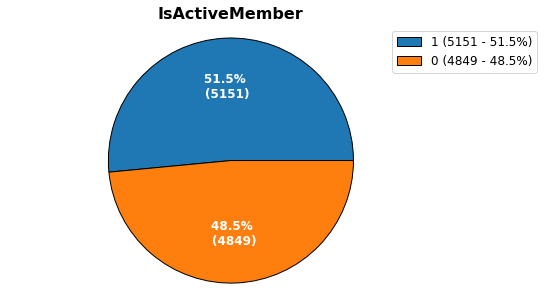

In [36]:
df_IsActiveMember = percentCol(df, 'IsActiveMember')
pie_chart(df_IsActiveMember, title='IsActiveMember')

Exited             0     1
IsActiveMember            
1               4416   735
0               3547  1302


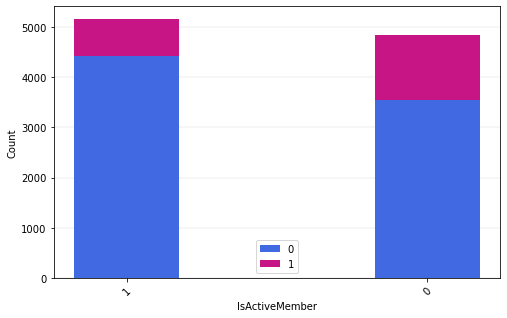

In [37]:
stacked_bar_chart(df, "IsActiveMember", "Exited")

In [38]:
print('{:.1%} of customers who are not active their accounts.'.format(1302/(3547+1302)))
print('=====')
print('{:.1%} of customers who are active closed their accounts.'.format(735/(4416+735)))

26.9% of customers who are not active their accounts.
=====
14.3% of customers who are active closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [39]:
df = one_hot_encoding(train=df, ohe_col='IsActiveMember')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,...,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,1,15634602,Hargrave,619,42,2,0.00,101348.88,1,1,...,1,0,1,0,0,0,0,1,0,1
1,2,15647311,Hill,608,41,1,83807.86,112542.58,0,0,...,1,0,1,0,0,0,1,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,113931.57,1,1,...,1,0,0,0,1,0,0,1,1,0
3,4,15701354,Boni,699,39,1,0.00,93826.63,0,1,...,1,0,0,1,0,0,1,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,79084.10,0,0,...,1,0,1,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Age
    </h4>
</div>

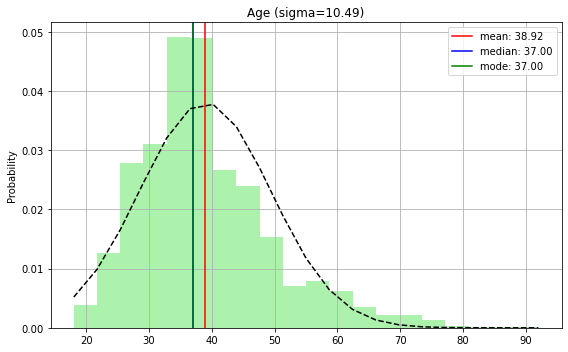

In [40]:
histogram(df, "Age")

In [41]:
print(f"min. Age: {df['Age'].min()}, \nmax. Age: {df['Age'].max()}")

min. Age: 18, 
max. Age: 92


In [42]:
bins = [df['Age'].min()-1,20,30,40,50,60,70, df['Age'].max()+1]
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Categorize the 'Customer_Age' column with the labels and bins and create a new column in the df dataframe
df['AgeGrb'] = pd.cut(df['Age'], bins=bins, labels=labels)
df['AgeGrb'] = df['AgeGrb'].cat.add_categories('unknown').fillna('unknown')
df.drop("Age", axis=1, inplace=True)

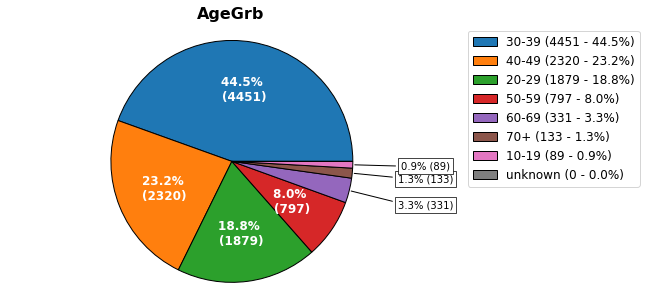

In [43]:
df_AgeGrb = percentCol(df, 'AgeGrb')
pie_chart(df_AgeGrb, title='AgeGrb', legend_pos=(1.03, 0, 0.4, 1))

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [44]:
df = one_hot_encoding(train=df, ohe_col='AgeGrb')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Tenure,Balance,EstimatedSalary,Exited,Geography_France,Geography_Germany,...,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,AgeGrb_10-19,AgeGrb_20-29,AgeGrb_30-39,AgeGrb_40-49,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+
0,1,15634602,Hargrave,619,2,0.00,101348.88,1,1,0,...,1,0,1,0,0,0,1,0,0,0
1,2,15647311,Hill,608,1,83807.86,112542.58,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,3,15619304,Onio,502,8,159660.80,113931.57,1,1,0,...,1,1,0,0,0,0,1,0,0,0
3,4,15701354,Boni,699,1,0.00,93826.63,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,5,15737888,Mitchell,850,2,125510.82,79084.10,0,0,0,...,1,0,1,0,0,0,1,0,0,0


<div class="alert alert-block alert-success">
    <h4>
        Balance
    </h4>
</div>

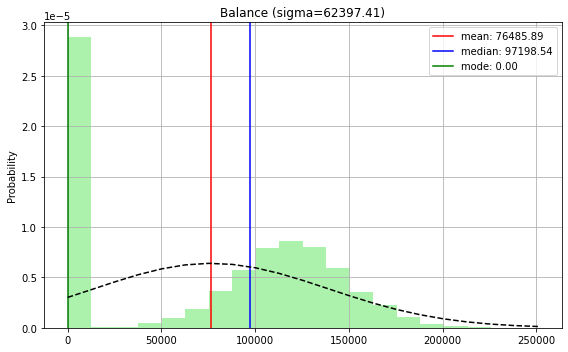

In [45]:
histogram(df, "Balance")

In [46]:
print(f"min. Balance: {df['Balance'].min()}, \nmax. Balance: {df['Balance'].max()}")

min. Balance: 0.0, 
max. Balance: 250898.09


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [47]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df[["Balance"]])
df["Balance_mm"] = minMaxScaler.transform(df[["Balance"]])
df.drop(["Balance"], axis=1, inplace=True)

<div class="alert alert-block alert-success">
    <h4>
        EstimatedSalary
    </h4>
</div>

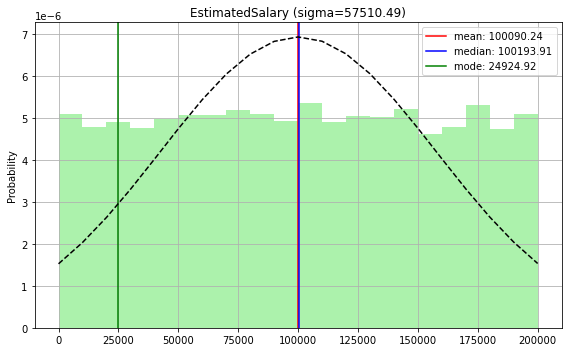

In [48]:
histogram(df, "EstimatedSalary")

In [49]:
print(f"min. EstimatedSalary: {df['EstimatedSalary'].min()}, \nmax. EstimatedSalary: \
{df['EstimatedSalary'].max()}")

min. EstimatedSalary: 11.58, 
max. EstimatedSalary: 199992.48


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [50]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df[["EstimatedSalary"]])
df["EstimatedSalary_mm"] = minMaxScaler.transform(df[["EstimatedSalary"]])
df.drop(["EstimatedSalary"], axis=1, inplace=True)

<div class="alert alert-block alert-success">
    <h4>
        CreditScore
    </h4>
</div>

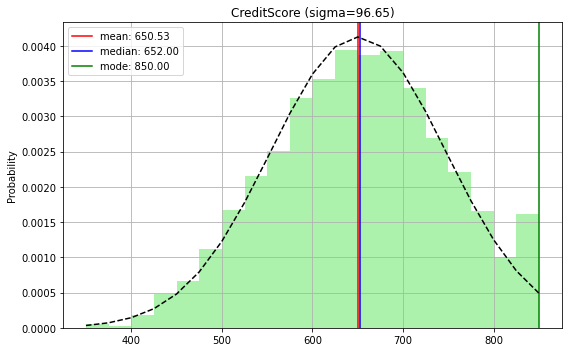

In [51]:
histogram(df, "CreditScore")

In [52]:
print(f"min. CreditScore: {df['CreditScore'].min()}, \nmax. CreditScore: \
{df['CreditScore'].max()}")

min. CreditScore: 350, 
max. CreditScore: 850


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [53]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df[["CreditScore"]])
df["CreditScore_mm"] = minMaxScaler.transform(df[["CreditScore"]])
df.drop(["CreditScore"], axis=1, inplace=True)

<div class="alert alert-block alert-success">
    <h4>
        Tenure
    </h4>
</div>

The first 8 items have been plotted.


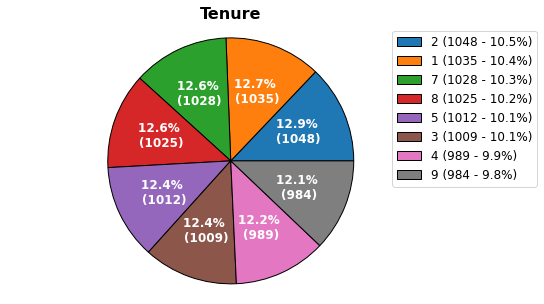

In [54]:
df_Tenure = percentCol(df, 'Tenure')
pie_chart(df_Tenure, title='Tenure')

The first 8 items have been plotted.
Exited    0    1
Tenure          
2       847  201
1       803  232
7       851  177
8       828  197
5       803  209
3       796  213
4       786  203
9       771  213


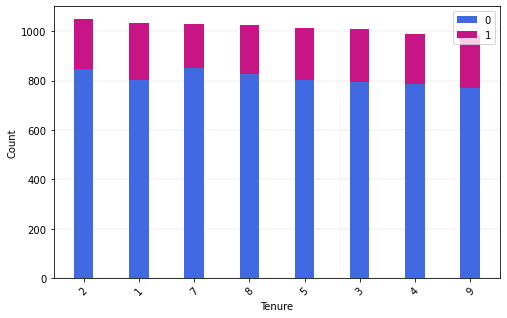

In [55]:
stacked_bar_chart(df, "Tenure", "Exited")

<div class="alert alert-block alert-success">
    <h4>
        CustomerId
    </h4>
</div>

In [56]:
customerId_category = []
for i in df['CustomerId']:
    customerId_category.append(str(i)[:3])
df['customerId_category'] = customerId_category
df.drop(['CustomerId'], axis=1, inplace=True)

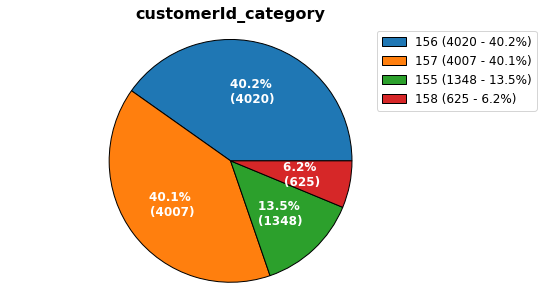

In [57]:
df_customerId_category = percentCol(df, 'customerId_category')
pie_chart(df_customerId_category, title='customerId_category')

Exited                  0    1
customerId_category           
156                  3211  809
157                  3204  803
155                  1055  293
158                   493  132


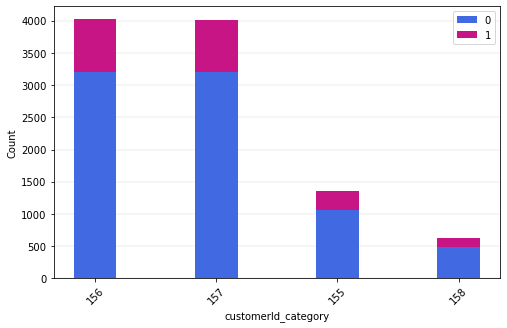

In [58]:
stacked_bar_chart(df, 'customerId_category', 'Exited')

In [59]:
print('{:.1%} of customers with 155 ID closed their accounts.'.format(293/(1055+293)))
print('=====')
print('{:.1%} of customers with 156 ID closed their accounts.'.format(809/(3211+809)))
print('=====')
print('{:.1%} of customers with 157 ID closed their accounts.'.format(803/(3211+803)))
print('=====')
print('{:.1%} of customers with 158 ID closed their accounts.'.format(132/(493+132)))

21.7% of customers with 155 ID closed their accounts.
=====
20.1% of customers with 156 ID closed their accounts.
=====
20.0% of customers with 157 ID closed their accounts.
=====
21.1% of customers with 158 ID closed their accounts.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [60]:
df = one_hot_encoding(train=df, ohe_col='customerId_category')
df.head()

,RowNumber,Surname,Tenure,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,...,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+,Balance_mm,EstimatedSalary_mm,CreditScore_mm,customerId_category_155,customerId_category_156,customerId_category_157,customerId_category_158
0,1,Hargrave,2,1,1,0,0,1,0,1,...,0,0,0,0.000000,0.506735,0.538,0,1,0,0
1,2,Hill,1,0,0,0,1,1,0,1,...,0,0,0,0.334031,0.562709,0.516,0,1,0,0
2,3,Onio,8,1,1,0,0,1,0,0,...,0,0,0,0.636357,0.569654,0.304,0,1,0,0
3,4,Boni,1,0,1,0,0,1,0,0,...,0,0,0,0.000000,0.469120,0.698,0,0,1,0
4,5,Mitchell,2,0,0,0,1,1,0,1,...,0,0,0,0.500246,0.395400,1.000,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Drop features
    </h4>
</div>

In [61]:
df = df.drop(['RowNumber', 'Surname'], axis=1)

<div class="alert alert-block alert-success">
    <h4>
        Move the label column to end and encodes it
    </h4>
</div>

In [62]:
new_cols_order = [i for i in df.columns if not i in "Exited"] + ["Exited"]
df = df.loc[:, new_cols_order]
df.head()

,Tenure,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,...,AgeGrb_60-69,AgeGrb_70+,Balance_mm,EstimatedSalary_mm,CreditScore_mm,customerId_category_155,customerId_category_156,customerId_category_157,customerId_category_158,Exited
0,2,1,0,0,1,0,1,0,0,0,...,0,0,0.000000,0.506735,0.538,0,1,0,0,1
1,1,0,0,1,1,0,1,0,0,0,...,0,0,0.334031,0.562709,0.516,0,1,0,0,0
2,8,1,0,0,1,0,0,0,1,0,...,0,0,0.636357,0.569654,0.304,0,1,0,0,1
3,1,1,0,0,1,0,0,1,0,0,...,0,0,0.000000,0.469120,0.698,0,0,1,0,0
4,2,0,0,1,1,0,1,0,0,0,...,0,0,0.500246,0.395400,1.000,0,0,1,0,0


<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature Engineering
   </h3>
</div>

In [63]:
X = df.drop('Exited', axis=1)
y = df['Exited']

<div class="alert alert-block alert-success">
    <h4>
        Check categorical columns
    </h4>
</div>

In [64]:
categorical_feature_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
categorical_feature_cols

[]

- There is no categorical columns in the dataframe

In [65]:
numerical_feature_cols = list(X._get_numeric_data().columns)
print(numerical_feature_cols)

['Tenure', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0', 'IsActiveMember_1', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_30-39', 'AgeGrb_40-49', 'AgeGrb_50-59', 'AgeGrb_60-69', 'AgeGrb_70+', 'Balance_mm', 'EstimatedSalary_mm', 'CreditScore_mm', 'customerId_category_155', 'customerId_category_156', 'customerId_category_157', 'customerId_category_158']


<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value

<div class="alert alert-block alert-warning">
        Constant
</div>

In [66]:
from sklearn.feature_selection import VarianceThreshold
constant=VarianceThreshold(threshold=0)
constant.fit(X)

constant_columns = [column for column in X.columns
                    if column not in X.columns[constant.get_support()]]
print(len(constant_columns))

0


<div class="alert alert-block alert-warning">
        Quasi constant
</div>

In [67]:
# # Quasi constant
# from sklearn.feature_selection import VarianceThreshold
# quasi_constant=VarianceThreshold(threshold=0.01)
# quasi_constant.fit(X)

# quasi_constant_columns = [column for column in X.columns
#                     if column not in X.columns[quasi_constant.get_support()]]
# print(quasi_constant_columns)

In [68]:
# X = pd.DataFrame(quasi_constant.transform(X), columns=X.columns[quasi_constant.get_support()])
# X.shape

<div class="alert alert-block alert-success">
    <h4>
        Remove duplicate features
    </h4>
</div>

In [69]:
X_T = X.T

In [70]:
X_T.duplicated().sum()

0

In [71]:
# features_to_keep = [not ind for ind in X_T.duplicated()]
# X = X_T[features_to_keep].T

- There are no dublicated features

<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

In [72]:
def highly_correlated_features(df, threshold):
    corr_matrix = df.corr()
    
    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = abs(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(df, 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

,Feature_1,Feature_2,Corr_value
1,NumOfProducts_2,NumOfProducts_1,0.936709
3,IsActiveMember_1,IsActiveMember_0,1.000000
2,HasCrCard_1,HasCrCard_0,1.000000
0,Gender_Male,Gender_Female,1.000000


<div class="alert alert-block alert-warning">
        Feature importance based on RandomForestClassifier 
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [73]:
from sklearn.ensemble import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]        
        
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list

        rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        rf.fit(df[correlated_features_list], y)
        # create an importance dataframe using the feature_importances_ values
        df_importance = pd.concat([pd.Series(correlated_features_list), pd.Series(rf.feature_importances_)], 
                               axis=1)
        df_importance.columns = ['Feature', 'Importance']
        df_importance.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_importance['Feature'][1:].values)
    
print(dropped_feature_list)  

['NumOfProducts_1', 'IsActiveMember_1', 'HasCrCard_1', 'Gender_Male']


In [74]:
# drop the highly correlated features 
X = X.drop(dropped_feature_list, axis=1)
print(X.shape)

(10000, 24)


<div class="alert alert-block alert-success">
    <h4>
        SelectFromModel using Logistic Regression
    </h4>
</div>

In [75]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def feature_selection(model, X_train, y_train):
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = cvs.mean()
    
    return acc

In [76]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
sfm = SFM(model).fit(X, y)
cols_SFM = X.columns[sfm.get_support()].tolist()
print(cols_SFM)

acc = feature_selection(model, X, y)
acc_SFM = feature_selection(model, X[cols_SFM], y)

print('The Accuracy all features: {:.1%}'.format(acc))
print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))

['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%


<div class="alert alert-block alert-success">
    <h4>
        GenericUnivariateSelect and ANOVA F-value
    </h4>
</div>

In [77]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

def best_features (model, X_train, y_train, cols_sel, cols_SFM, acc, acc_SFM):
    cols_model_best = []
    acc_model_best = 0
    for col in cols_sel:
        if col not in cols_SFM:
            cols_SFM = cols_SFM + [col]
            cv = KFold(n_splits=10, random_state=0, shuffle=True)
            cvs_model = cross_val_score(model, X_train[cols_SFM], y_train, scoring='accuracy', cv=cv)
            acc_model = cvs_model.mean()
            if (acc_model > acc_SFM) & (acc_model > acc_model_best):
                cols_model_best = cols_SFM
                acc_model_best = acc_model
                print(cols_model_best)
                print('The Accuracy all features: {:.1%}'.format(acc))
                print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
                print('The Accuracy selected features with MODEL: {:.1%}'.format(acc_model_best))
                print('=====')

In [78]:
from sklearn.feature_selection import GenericUnivariateSelect as GUS
# ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import f_classif

gus_f = GUS(f_classif, mode='k_best', param=len(X.columns)).fit(X, y)
cols_gus_f = X.columns[gus_f.get_support()].tolist()

best_features(model, X, y, cols_gus_f, cols_SFM, acc, acc_SFM)

['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 83.9%
=====
['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France', 'Geography_Germany']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 84.1%
=====
['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France', 'Geography_Germany', 'Geography_Spain']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 84.1%
=====
['NumOfProducts_2'

<div class="alert alert-block alert-success">
    <h4>
        SelectKBest and Mutual Information
    </h4>
</div>

In [79]:
from sklearn.feature_selection import SelectKBest
# Mutual information for a discrete target.
from sklearn.feature_selection import mutual_info_classif

# select the  top k important features
KBest_m = SelectKBest(mutual_info_classif, k=len(X.columns)).fit(X, y)
cols_KBest_m = X.columns[KBest_m.get_support()].tolist()

best_features(model, X, y, cols_KBest_m, cols_SFM, acc, acc_SFM)

['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 83.9%
=====
['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France', 'Geography_Germany']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 84.1%
=====
['NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Tenure', 'Geography_France', 'Geography_Germany', 'Geography_Spain']
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with MODEL: 84.1%
=====
['NumOfProducts_2'

<div class="alert alert-block alert-success">
    <h4>
        RFE (Recursive feature elimination)
    </h4>
</div>

In [80]:
from sklearn.feature_selection import RFE

new_cols_RFE = cols_SFM.copy()
acc_RFE_best = 0
new_cols_RFE_best = []

for i in range(10, len(X.columns)+1):
    selector = RFE(estimator=model, n_features_to_select=i).fit(X, y)
    new_cols_RFE = X.columns[selector.get_support()]
    
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs_RFE = cross_val_score(model, X[new_cols_RFE], y, scoring='accuracy', cv=cv)
    acc_RFE = cvs_RFE.mean()
    
    if acc_RFE > acc_RFE_best:
        acc_RFE_best = acc_RFE
        new_cols_RFE_best = new_cols_RFE
        
        print(new_cols_RFE_best)
        print('The Accuracy all features: {:.1%}'.format(acc))
        print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
        print('The Accuracy selected features with KBest: {:.1%}'.format(acc_RFE_best))
        print('=====')

Index(['Geography_Germany', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29',
       'AgeGrb_40-49', 'AgeGrb_50-59', 'AgeGrb_60-69'],
      dtype='object')
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with KBest: 85.2%
=====
Index(['Geography_Germany', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'IsActiveMember_0', 'AgeGrb_10-19', 'AgeGrb_20-29',
       'AgeGrb_30-39', 'AgeGrb_40-49', 'AgeGrb_50-59', 'AgeGrb_60-69'],
      dtype='object')
The Accuracy all features: 85.3%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with KBest: 85.2%
=====
Index(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'HasCrCard_0', 'IsActiveMember_0', 'AgeGrb_10-19',
       'AgeGrb_20-29', 'AgeGrb_30-39', 'AgeGrb_40-49', 'AgeGrb_5

<a id='5.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

In [81]:
selected_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'HasCrCard_0', 'IsActiveMember_0', 'AgeGrb_10-19',
       'AgeGrb_20-29', 'AgeGrb_30-39', 'AgeGrb_40-49', 'AgeGrb_50-59',
       'AgeGrb_60-69', 'AgeGrb_70+', 'Balance_mm', 'EstimatedSalary_mm',
       'CreditScore_mm', 'customerId_category_155', 'customerId_category_156',
       'customerId_category_158']
X = X[selected_features]
print(X.shape)

(10000, 22)


In [82]:
def create_heatmap(hm, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

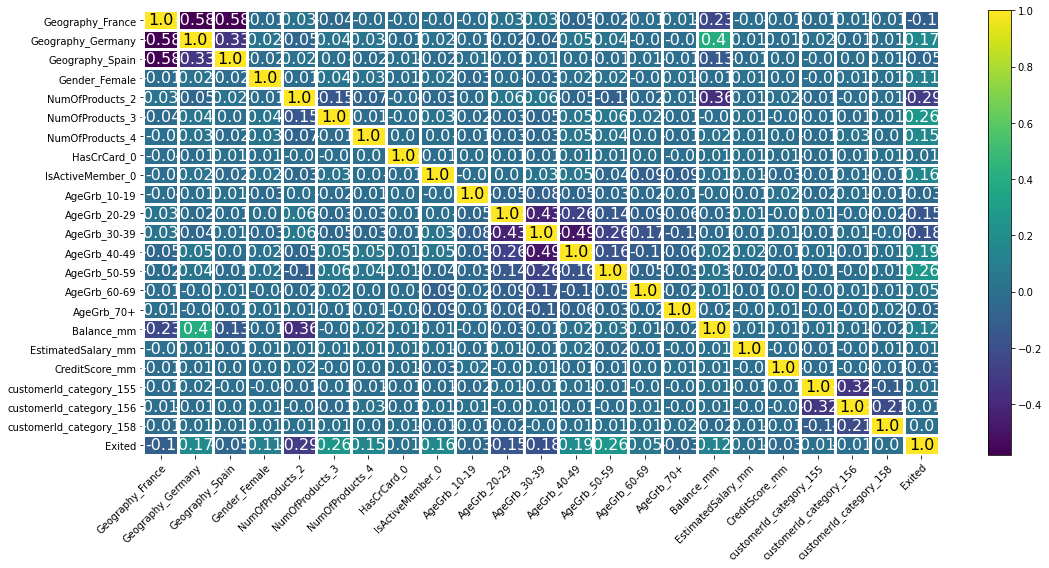

In [83]:
hm_train_new = pd.concat([X, y], axis=1).corr()
create_heatmap(hm_train_new)

In [84]:
cols_dropped = list(hm_train_new[(hm_train_new["Exited"] > -0.03)&(hm_train_new["Exited"] < 0.03)]\
                    ["Exited"].index)
print(cols_dropped)

['HasCrCard_0', 'EstimatedSalary_mm', 'CreditScore_mm', 'customerId_category_155', 'customerId_category_156', 'customerId_category_158']


In [85]:
X.drop(cols_dropped, axis=1, inplace=True)

<a id='5.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Split Dataframe
   </h3>
</div>

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=0)

print(X_train.shape)
print(X_test.shape)

(7000, 16)
(3000, 16)


<a id='5.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Overcoming Class Imbalance using SMOTE
   </h3>
</div>

- It is an imbalanced data where the target variable, churn has 79.7% customers not churning and 20.3% customers who have churned
- SMOTE: Synthetic Minority Oversampling Technique will be used for creating synthesized data
- A comparative analysis will be done on the dataset using RandomForestClassifier
- The accuracy metric will be ignored to evaluate the performance of the classifier on this imbalanced dataset
- Precision, recall, F1-score metrics will be taken into account 

<div class="alert alert-block alert-warning">
        SMOTE: Synthetic Minority Oversampling Technique
</div>

- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
- Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

<img src="https://editor.analyticsvidhya.com/uploads/64068image3.png" style="height:250px">

In [87]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [88]:
df_Exited_smote = percentCol(pd.concat([X_train_sm, y_train_sm], axis=1), 'Exited')

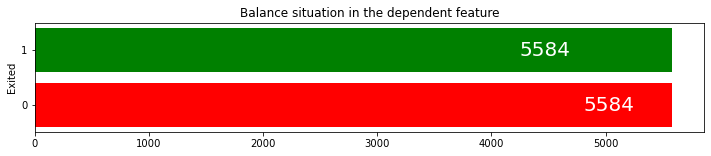

In [89]:
balanceOrInbalance(df_Exited_smote)

<div class="alert alert-block alert-success">
    <h4>
        Comparison
    </h4>
</div>

In [90]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

<div class="alert alert-block alert-warning">
        Before
</div>

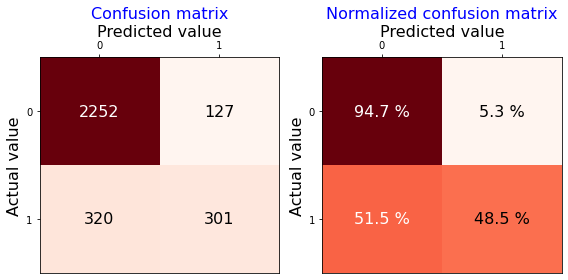

In [91]:
from sklearn.linear_model import LogisticRegression

params = {}
log = LogisticRegression()
log_cm_metrics, log_pred = evaluate_model(log, X_train, y_train, X_test, y_test, params)

In [92]:
# evaluate_model(rf, X_train, y_train, X_test, y_test)

<div class="alert alert-block alert-warning">
        After
</div>

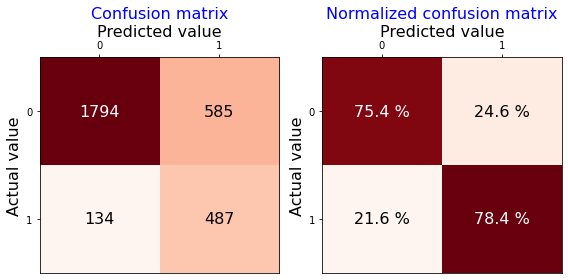

In [93]:
from sklearn.linear_model import LogisticRegression

params = {}
log = LogisticRegression()
log_cm_metrics, log_pred = evaluate_model(log, X_train_sm, y_train_sm, X_test, y_test, params)

In [94]:
# evaluate_model(rf, X_train_sm, y_train_sm, X_test, y_test)

- There is an increase in some metrics, especially in Recall

<a id='5.5'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Logistic
    </h4>
</div>

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png" style="height:150px">

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='none', C=0, solver='newton-cg', max_iter=25, multi_class='auto')
# params = {
# #     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
# #     'C': [i for i in np.arange(0, 5, 15)],
# #     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
# #     'max_iter': [5,15,25],
#     'multi_class': ['auto', 'ovr', 'multinomial'],
#          }
# clf_log = GridSearchCV(estimator=log, cv=10, scoring='accuracy', param_grid=params, 
#                        n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_log.best_params_)

# acc_log = clf_log.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_log))

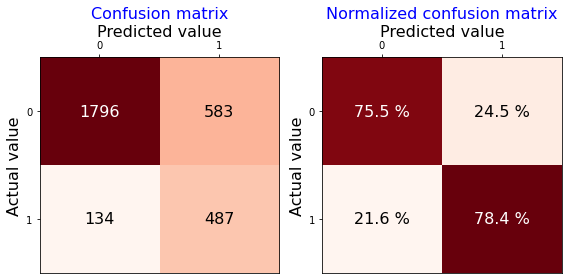

In [96]:
params = {
    'penalty': ['none'],
    'C': [0],
    'solver': ['newton-cg'],
    'max_iter': [25],
    'multi_class': ['auto'],
         }
log = LogisticRegression()
log_cm_metrics, log_pred = evaluate_model(log, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Random Forest
    </h4>
</div>

<img src="https://406167-1278791-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/Random-Forest-Algorithm-1024x576.jpg" style="height:250px">

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=125, criterion='gini', max_depth=15, 
                            min_samples_split=10, min_samples_leaf=1)

# params = {
#     'n_estimators': [50, 100, 125, 150, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10, 15, 20, 25, 30],
#     'min_samples_split': [5, 10, 15, 20, 25, 30],
#     'min_samples_leaf': [1, 3, 5, 10, 15, 20, 25, 30],
#          }
# clf_rf = GridSearchCV(estimator=rf, cv=10, scoring='accuracy', param_grid=params, n_jobs=-1)\
# .fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_rf.best_params_)
# acc_rf = clf_rf.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_rf))

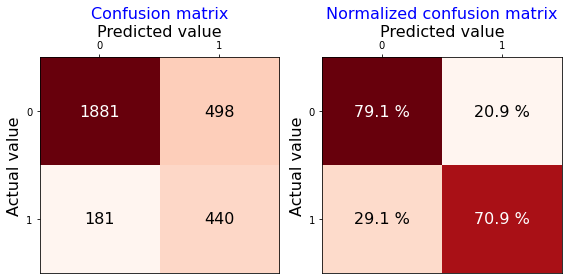

In [98]:
params = {
    'n_estimators': [125],
    'criterion': ['gini'],
    'max_depth': [15],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
         }
rf = RandomForestClassifier()
rf_cm_metrics, rf_pred = evaluate_model(rf, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes
    </h4>
</div>

<img src="https://www.researchgate.net/profile/Paolo-Dellaversana/publication/328020065/figure/fig5/AS:677213301121033@1538471641906/Naive-Bayes-classification-of-three-different-rock-types-based-on-nine-mineralogical.png" style="height:200px">

In [99]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bNB = BernoulliNB(alpha=0.5, binarize=0.5, fit_prior=True)

# params = {
#     'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
#     'binarize': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'fit_prior': [False, True],
#          }
# clf_bNB = GridSearchCV(estimator=bNB, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_bNB.best_params_)
# acc_bNB = clf_bNB.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_bNB))

CPU times: user 2.24 ms, sys: 1.54 ms, total: 3.77 ms
Wall time: 1.6 ms


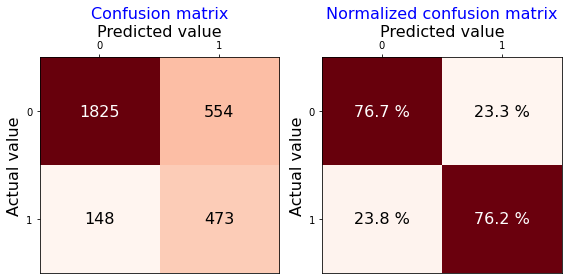

In [100]:
params = {
    'alpha': [0.5],
    'binarize': [0.5],
    'fit_prior': [True],
         }
bNB = BernoulliNB()
bNB_cm_metrics, bNB_pred = evaluate_model(bNB, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Support Vector
    </h4>
</div>

<img src="https://miro.medium.com/max/410/1*MHtUN-DgYPZWPe2dU5G6Lg.png" style="height:200px">

In [101]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(C=2.5, kernel='rbf', degree=0.1, probability=True)

# params = {
# #     'C': [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5],
# #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'degree': [0.1, 0.5, 1, 2, 3, 4, 5, 6],
#          }
# clf_svm = GridSearchCV(estimator=svm, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_svm.best_params_)
# acc_svm = clf_svm.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_svm))

CPU times: user 41 µs, sys: 42 µs, total: 83 µs
Wall time: 17.9 µs


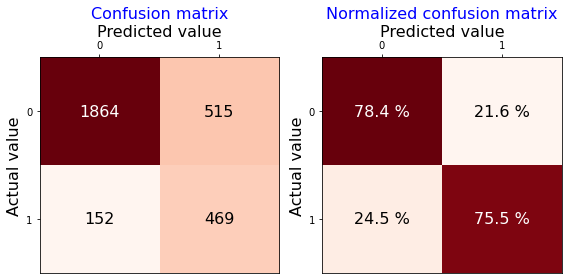

In [102]:
params = {
    'C': [2.5],
    'kernel': ['rbf'],
    'degree': [0.1],
         }
svm = SVC(probability=True)
svm_cm_metrics, svm_pred = evaluate_model(svm, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        k-Nearest Neighbours
    </h4>
</div>

<img src="https://www.kdnuggets.com/wp-content/uploads/rapidminer-knn-image1.jpg" style="height:200px">

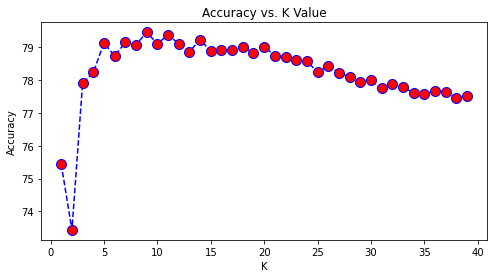

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

acc_list = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sm, y_train_sm)
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    accuracy_scores = cross_val_score(knn, X_train_sm, y_train_sm, scoring='accuracy', cv=cv, n_jobs=-1)
    acc_knn = round(accuracy_scores.mean()*100, 2)
#     acc_knn = evaluate_model(knn, X_train_sm, y_train_sm)
    acc_list.append(acc_knn)
    
plt.figure(figsize=(8,4))
plt.plot(range(1,40),acc_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [104]:
k_max_list = [i for i in acc_list]
k_max = acc_list.index(max(k_max_list))+1
print(k_max)

9


In [105]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=5, weights='uniform', p=2)

# params = {
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
# #     'leaf_size': [5, 10, 15, 20, 25, 30, 35],
# #     'weights': ['uniform', 'distance'],
# #     'p': [1, 2, 3, 4, 5, 6],
#          }
# clf_knn = GridSearchCV(estimator=knn, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_knn.best_params_)
# acc_knn = clf_knn.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_knn))

CPU times: user 21 µs, sys: 15 µs, total: 36 µs
Wall time: 37 µs


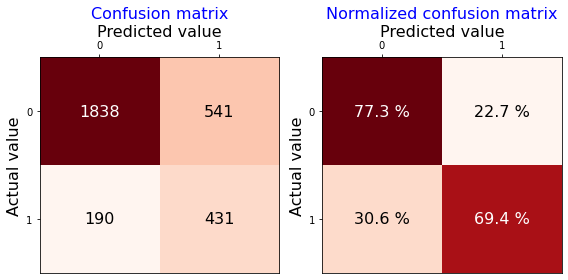

In [106]:
params = {
    'algorithm': ['auto'],
    'leaf_size': [5],
    'weights': ['uniform'],
    'p': [2],
         }
knn = KNeighborsClassifier()
knn_cm_metrics, knn_pred = evaluate_model(knn, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Stochastic Gradient Descent
    </h4>
</div>

<img src="https://miro.medium.com/max/1005/1*f0CuPDSWFUr9XGESWQ4JUA.png" style="height:200px">

In [107]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss='log', penalty='l1', alpha=0.0002, learning_rate='adaptive', 
                     eta0=0.03, power_t=0.07, validation_fraction=0.07, n_iter_no_change=1)

# params = {
# #     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
# #              'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
# #     'penalty': ['l1', 'l2', 'elasticnet'],
# #     'alpha': [i for i in np.arange(0.0001, 0.001, 1/10000)],
# #     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
# #     'eta0': [0.01, 0.03, 0.05, 0.07],
# #     'power_t': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
# #     'validation_fraction': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
# #     'n_iter_no_change': [1, 3, 5, 7, 9, 11],
#          }
# clf_sgdc = GridSearchCV(estimator=sgdc, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_sgdc.best_params_)
# acc_sgdc = clf_sgdc.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_sgdc))

CPU times: user 153 µs, sys: 89 µs, total: 242 µs
Wall time: 82 µs


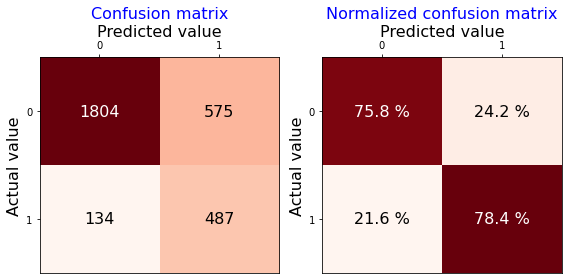

In [108]:
params = {
    'loss': ['log'],
    'penalty': ['l1'],
    'alpha': [0.0002],
    'learning_rate': ['adaptive'],
    'eta0': [0.03],
    'power_t': [0.07],
    'validation_fraction': [0.07],
    'n_iter_no_change': [1],
         }
sgdc = SGDClassifier()
sgdc_cm_metrics, sgdc_pred = evaluate_model(sgdc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Gradient Boosting Trees
    </h4>
</div>

<img src="https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png" style="height:200px">

In [109]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.2, n_estimators=120, criterion='mse',
                                max_depth=2, subsample=0.9)

# params = {
# #         'loss': ['deviance', 'exponential'],
# #     'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3, 0.35],
# #     'n_estimators': [20,40,80,100,120],
# #     'subsample':[0.9,0.95,1,1.1],
#     'criterion': ['friedman_mse', 'mse', 'mae'],
# #     'max_depth': [1,2,3,4,6,8],
#          }
# clf_gbc = GridSearchCV(estimator=gbc, cv=10, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_gbc.best_params_)
# acc_gbc = clf_gbc.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_gbc))

CPU times: user 209 µs, sys: 234 µs, total: 443 µs
Wall time: 65.8 µs


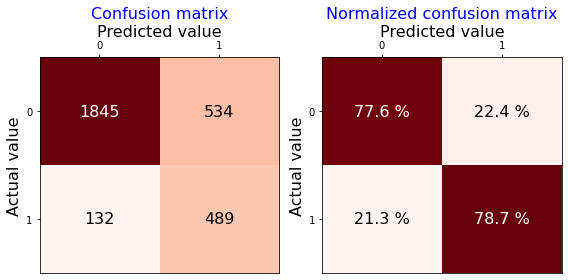

In [110]:
params = {
    'loss': ['exponential'],
    'learning_rate': [0.2],
    'n_estimators': [120],
    'subsample':[0.9],
    'criterion': ['mse'],
    'max_depth': [2],
         }
gbc = GradientBoostingClassifier()
gbc_cm_metrics, gbc_pred = evaluate_model(gbc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        xgboost -> XGBClassifier
    </h4>
</div>

In [111]:
%%time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.07, max_depth=4, 
                min_child_weight=2.8, n_estimators=80, max_delta_step=2, subsample=1, 
                    use_label_encoder=False)

# params = {
# #     'sketch_eps': [i for i in np.arange(0, 0.1, 1/100)],
# #     'eta': [0.01,0.03,0.05,0.07,0.09],
# #     'max_depth': [4,6,8,10,12],
# #     'n_estimators': [20,40,80,120],
# #     'min_child_weight' : [2.5,2.6,2.7,2.8,2.9,3],
# #     'max_delta_step':[1,1.5,2],
# #     'subsample':[0.9,0.95,1]
#          }
# clf_xgb = GridSearchCV(estimator=xgb, cv=5, scoring='accuracy', param_grid=params, 
# n_jobs=-1).fit(X_train_sm, y_train_sm)
# print('best prarams:', clf_xgb.best_params_)
# acc_xgb = clf_xgb.best_score_
# print('The Accuracy  on the training dataset is: {:.1%}'.format(acc_xgb))

CPU times: user 133 ms, sys: 46 ms, total: 179 ms
Wall time: 79.1 ms


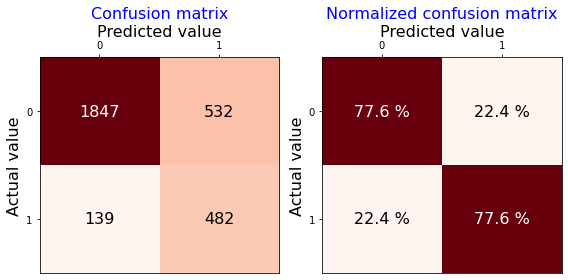

In [112]:
params = {
    'sketch_eps': [0.0],
    'eta': [0.07],
    'max_depth': [4],
    'n_estimators': [80],
    'min_child_weight' : [2.8],
    'max_delta_step':[2],
    'subsample':[1]
         }
xgb = XGBClassifier(booster='gbtree', eval_metric='logloss')
xgb_cm_metrics, xgb_pred = evaluate_model(xgb, X_train_sm, y_train_sm, X_test, y_test, params)

<a id='5.6'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [113]:
'''
    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)
    
    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
'''

metrics = ["Accuracy", "True Negative Rate", "True Positive Rate", "Precision", "F1 Score"]

log_metrics = log_cm_metrics.loc[:, metrics]
rf_metrics = rf_cm_metrics.loc[:, metrics]
bNB_metrics = bNB_cm_metrics.loc[:, metrics]
svm_metrics = svm_cm_metrics.loc[:, metrics]
knn_metrics = knn_cm_metrics.loc[:, metrics]
sgdc_metrics = sgdc_cm_metrics.loc[:, metrics]
gbc_metrics = gbc_cm_metrics.loc[:, metrics]
xgb_metrics = xgb_cm_metrics.loc[:, metrics]

df_models = pd.concat([log_metrics, rf_metrics, bNB_metrics, svm_metrics, knn_metrics, sgdc_metrics, 
                       gbc_metrics, xgb_metrics], axis=0)
df_models.index = ["log", "rf", "bNB", "svm", "knn", "sgdc", "gbc", "xgb"]
df_models = df_models.sort_values(["Accuracy", "True Positive Rate"], ascending=False)
df_models

,Accuracy,True Negative Rate,True Positive Rate,Precision,F1 Score
gbc,0.78,0.78,0.79,0.48,0.59
xgb,0.78,0.78,0.78,0.48,0.59
svm,0.78,0.78,0.76,0.48,0.58
bNB,0.77,0.77,0.76,0.46,0.57
rf,0.77,0.79,0.71,0.47,0.56
log,0.76,0.75,0.78,0.46,0.58
sgdc,0.76,0.76,0.78,0.46,0.58
knn,0.76,0.77,0.69,0.44,0.54


<a id='5.7'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        ROC & AUC
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Gradient Boosting Trees selected
</div>

In [114]:
y_test_prob = gbc_pred[:,1]

In [115]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_test_pred = (y_test_prob >= i/1000).astype('int')
    cm_train = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm_train.ravel()
    
    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_train = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR_train = round(TN / (TN + FP), 2)
    # False positive rate or False alarm rate
    FPR_train = round(FP / (FP + TN), 2)
    # accuracy (ACC)
    acc_train = round((TP + TN) / (TP + TN + FP + FN), 2)
    # Precision or positive predictive value
    precision_train = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    npv_train = round(TN / (TN + FN), 2)    

    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/1000)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 1.39 s, sys: 64.9 ms, total: 1.45 s
Wall time: 1.14 s


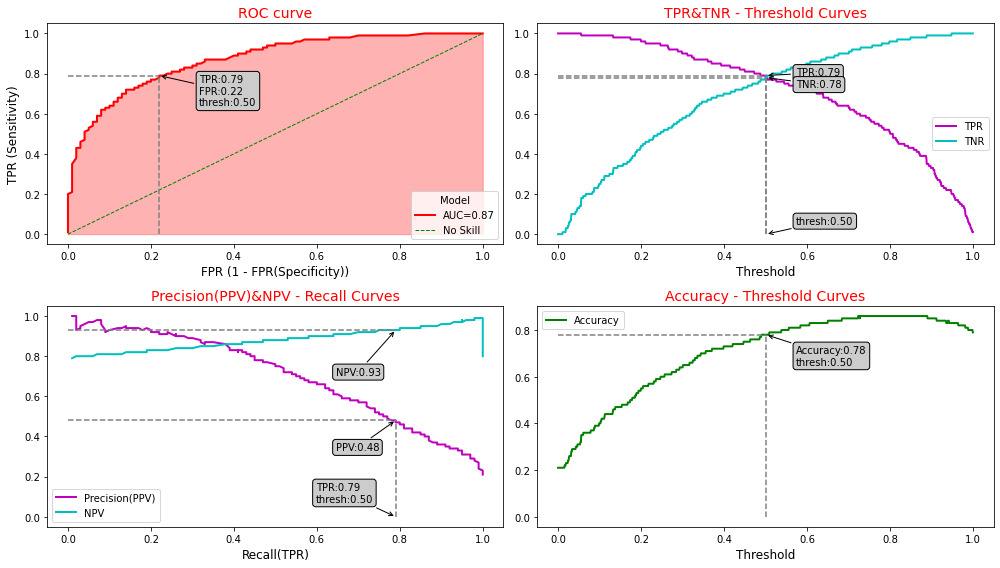

In [116]:
from sklearn.metrics import roc_auc_score

threshold=0.5
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_test, y_test_prob)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Logarithmic loss
    </h4>
</div>

- A lower log loss, a higher model success, means better predictions

In [117]:
from sklearn.metrics import log_loss
# Running Log loss on training
print('The Log Loss on Test is: {:.2}'.format(log_loss(y_test, y_test_prob)))

The Log Loss on Test is: 0.46


/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base

/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/